In [1]:
#IMPORT
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.integrate import cumtrapz, trapz
import time
import scipy.stats as stats
import h5py


#PYTHON MODULES
from constants import *
import gwcosmo
import gwpop
import gwutils
import utils
import sensitivity_curves as sc

#PLOTS
import sys
dir_base=sys.path[0]
dir_out=dir_base+"/data_injections/"

#from matplotlib.ticker import ScalarFormatter
#%config InlineBackend.figure_format = 'retina'
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')
fontSz = 15
fontsz = 13
fontssz = 11

new_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

# Injection campaign

When starting an injection campaign to compute the sensitivity of a given detector we need to sample detector frame masses and luminosity distances from some fiducial distributions

We load our fiducial universe parameters

In [2]:
from fiducial_universe import *

Settings for the sensitivity of our detector

In [3]:
fmin = 10.
detector = 'CE' 
det_Sc = sc.CE
based = 'ground'
snr_th = 8.

Find maximum detectable luminosity distance

In [5]:
mz_min,mz_max = 100.0, 2000.#500.0
log10dL_min,log10dL_max = np.log10(26000), np.log10(10000000)#np.log10(30000)

mzs = np.linspace(mz_min,mz_max,40)
dLs = np.logspace(log10dL_min,log10dL_max,40)
dL_hor = 0.
mz_hor = 0.

for i in range(len(mzs)):
    for j in range(len(dLs)):
        snr = gwutils.vsnr(mzs[i],mzs[i],dLs[j],fmin,Tobs_fid,det_Sc,based)
        if snr > snr_th:
            if dLs[j] > dL_hor:
                dL_hor = dLs[j]
                mz_hor = mzs[j]
print(dL_hor,mz_hor)

1375068.8670741431 1366.6666666666665


In [4]:
data_hor_O5 = np.genfromtxt('gw_horizon_data/zhor_max_o5_mobs.txt')
mtotz_hor_O5 = data_hor_O5[:,0]
z_hor_O5 = data_hor_O5[:,1]
print('Maximum horizon redshift for O5: ',np.max(z_hor_O5), ' at m = ',mtotz_hor_O5[np.argmax(z_hor_O5)])

data_hor_CE = np.genfromtxt('gw_horizon_data/zhor_max_ce_mobs.txt')
mtotz_hor_CE = data_hor_CE[:,0]
z_hor_CE = data_hor_CE[:,1]
print('Maximum horizon redshift for CE: ',np.max(z_hor_CE), ' at m = ',mtotz_hor_CE[np.argmax(z_hor_CE)])

Maximum horizon redshift for O5:  3.0458598670450185  at m =  442.30247994509773
Maximum horizon redshift for CE:  112.4191735683211  at m =  925.4664023757377


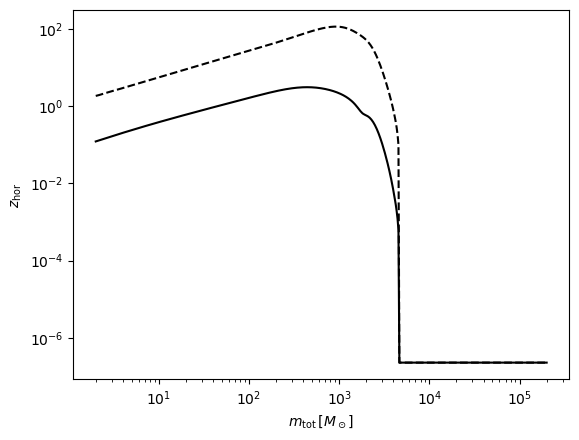

In [6]:
plt.loglog(mtotz_hor_O5,z_hor_O5,'k-',label='O5')
plt.plot(mtotz_hor_CE,z_hor_CE,'k--',label='CE')
plt.xlabel(r'$m_{\rm tot} \, [M_\odot]$')
plt.ylabel(r'$z_{\rm hor}$')
plt.show()

We sample in :
- Uniform log dL
- Power law for detector primary mass 
- Uniforma mass ratio

In [7]:
params = 'm1z_m2z_dL'

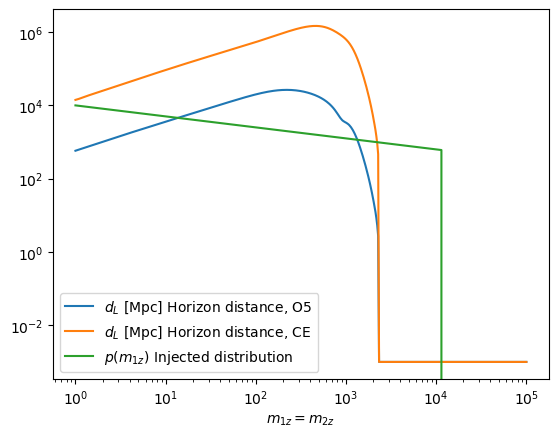

In [12]:

plt.loglog(mtotz_hor_O5/2,gwcosmo.dL_approx(z_hor_O5,H0_fid,Om0_fid),label=r'$d_L$ [Mpc] Horizon distance, O5')
plt.loglog(mtotz_hor_CE/2,gwcosmo.dL_approx(z_hor_CE,H0_fid,Om0_fid),label=r'$d_L$ [Mpc] Horizon distance, CE')

#Parameters for the injection are tunned by hand
zmax = 115
alpha_inj, mmin_inj, mmax_inj = -0.3, 1., 100.*(1+zmax)


plt.loglog(mtotz_hor_O5/2,1e7*gwpop.power_law(mtotz_hor_O5/2,alpha_inj, mmin_inj,mmax_inj),label=r'$p(m_{1z})$ Injected distribution')

#plt.ylim([1e2,1e5])
#plt.xlim([1,3e3])
plt.xlabel(r'$m_{1z}=m_{2z}$')
#plt.ylabel(r'')
plt.legend()
plt.show()

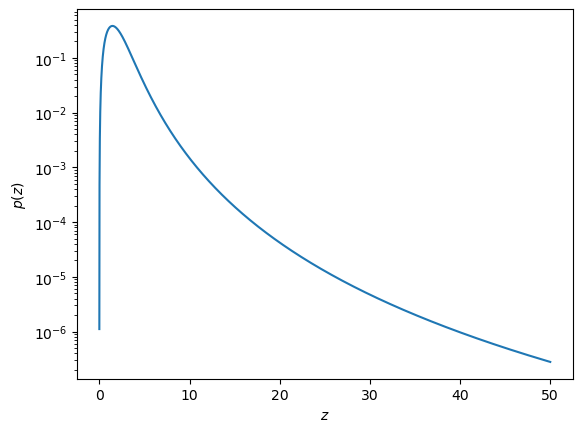

In [18]:
zs = np.linspace(0.001,50,10000)
pz = gwcosmo.diff_comoving_volume_approx(zs,H0_fid,Om0_fid)*gwpop.rate_z(zs,zp_fid,alpha_z_fid,beta_fid)/(1+zs)
pz = pz/trapz(pz,zs)

plt.semilogy(zs,pz)
plt.xlabel(r'$z$')
plt.ylabel(r'$p(z)$')
plt.show()

For the injections we want to:

- which injections are detected, as determined by observed SNR* larger than a fixed threshold
- the probability of each draw given the injected distributions

For the detector frame masses we are sampling with a power-law in the primary mass:

$$p(m_{1z})=\frac{(1+\alpha)}{(m_{1z,max})^{(1+\alpha)}-(m_{1z,min})^{(1+\alpha)}}m_{1z}^\alpha$$

, and uniform in the mass ratio:

$$p(q)=1$$

Since we are sampling uniformly in $\log_{10} d_L$ we need to include a Jacobian to transform to $d_L$:

$$p(d_L)=p'(\log_{10} d_L)|\frac{\partial \log_{10} d_L}{\partial d_L}|=\frac{1}{(\log_{10}d_{L}^{max}-\log_{10}d_L^{min})}\frac{\log_{10}e}{d_L}$$

In total

$$p_{draw}(m_{1z},d_L)=p(m_{1z})p(m_{2z})p(d_L)$$

The observed SNR is defined as a random instance of a normal distribution centered at the true SNR with variance 1. 

The true SNR is computed from the optimal SNR multiplied by the geometrical factor accounting for the random sky postion, inclination and polarization for a given detector network.

We do injections for $m_{1z}$, $m_{2z}$ and $d_L$

In [9]:
n_detections = int(1e1)
n_sources = n_detections*50


starttime = time.time()

##Defining the injected distribution CDFs
m1zs = np.linspace(mmin_inj,mmax_inj,10000)
cdf_m1z = cumtrapz(gwpop.power_law(m1zs,alpha_inj, mmin_inj,mmax_inj),m1zs,initial=0.0)
cdf_m1z = cdf_m1z / cdf_m1z[-1]
#Geometric factor from orientations
ww = np.linspace(0.0,1.0,1000)
cdf_ww = 1.0-gwutils.pw_hl(ww)

##Computing injected events
#----
#Detector frame primary mass
mz_min,mz_max = mmin_inj,mmax_inj
m1z_mock_pop = utils.inverse_transf_sampling(cdf_m1z,m1zs,n_sources)
m2z_mock_pop = np.random.uniform(mz_min,m1z_mock_pop,n_sources)
#Luminosity distance
log10dL_min,log10dL_max = 1., np.log10(27000.0)
log10dL_mock_pop = np.random.uniform(log10dL_min,log10dL_max,n_sources)
dL_mock_pop = np.power(10.0,log10dL_mock_pop)

#Optimal SNR
snr_opt_mock_pop = gwutils.vsnr(m1z_mock_pop,m2z_mock_pop,dL_mock_pop,fmin,Tobs_fid,det_Sc,based)
#True SNR
w_mock_pop = utils.inverse_transf_sampling(cdf_ww,ww,n_sources) #random draw
snr_true_mock_pop = snr_opt_mock_pop*w_mock_pop
#Observed SNR
snr_obs_mock_pop = gwutils.observed_snr(snr_true_mock_pop)

##Computing p_draw
p_draw_m1z = gwpop.power_law(m1z_mock_pop,alpha_inj, mmin_inj,mmax_inj)
p_draw_m2z = 1./(m1z_mock_pop-mz_min)
p_draw_logdL = 1./(log10dL_max-log10dL_min)
jac_logdLdL = np.log10(np.exp(1.))/dL_mock_pop
p_draw_mock_pop = p_draw_m1z * p_draw_logdL * jac_logdLdL * p_draw_m2z

#Detected injections
m1z_inj = m1z_mock_pop[snr_obs_mock_pop>snr_th]
m2z_inj = m2z_mock_pop[snr_obs_mock_pop>snr_th]
dL_inj = dL_mock_pop[snr_obs_mock_pop>snr_th]
p_draw_inj = p_draw_mock_pop[snr_obs_mock_pop>snr_th]

Ndet = np.size(m1z_inj)
Ndraws = n_sources
print('Ndet = ',Ndet,', Ndraw = ',Ndraws)
print('Time taken = {} seconds'.format(time.time() - starttime))

Ndet =  373 , Ndraw =  500
Time taken = 10.707141399383545 seconds


In [10]:
dir_out = 'data_injections/'
variables = ['m1z_inj','m2z_inj','dL_inj','p_draw_inj']
# Saving the data
with h5py.File(dir_out+'injections_'+detector+'_'+params+'_Ndraws_%s_Ndet_%s.hdf5' % (Ndraws,Ndet), "w") as f:
    for var in variables:
        dset = f.create_dataset(var, data=eval(var))

Checking the injections

In [7]:
Ndet = 3589378 #7178982
Ndraw = 5000000 #10000000

#Reading the data
data = h5py.File(dir_out+'injections_'+detector+'_'+params+'_Ndraws_%s_Ndet_%s.hdf5' % (Ndraw,Ndet), "r")
m1z_inj = np.array(data['m1z_inj'])
m2z_inj = np.array(data['m2z_inj'])
dL_inj = np.array(data['dL_inj'])
p_draw_inj = np.array(data['p_draw_inj'])

In [5]:
dir_inj = '/astro/ezquiaga/spectral_sirens/data_injections/'
detector = 'O5'
params = 'm1z_m2z_dL'
alpha_inj, mmin_inj, mmax_inj = -.3, 1., 500.
inj_details = 'Vz_m1z_power_law_alpha_%s_mmin_%s_mmax_%s' % (alpha_inj,mmin_inj,mmax_inj)
Ndet = 163278#3589378 #7178982 # _Ndet_
Ndraw = 1000000#5000000 #10000000 #
#Reading the data
data = h5py.File(dir_inj+'injections_'+detector+'_'+params+'_'+inj_details+'_Ndraws_%s_Ndet_%s.hdf5' % (Ndraw,Ndet), "r")
#data = h5py.File(dir_inj+'injections_'+detector+'_'+params+'_Ndraws_%s_Ndet_%s.hdf5' % (Ndraw,Ndet), "r")
m1z_inj = np.array(data['m1z_inj'])
m2z_inj = np.array(data['m2z_inj'])
dL_inj = np.array(data['dL_inj'])
p_draw_inj = np.array(data['p_draw_inj'])

In [6]:
dir_inj = '/astro/ezquiaga/spectral_sirens/data_injections/'
detector = 'O5'
params = 'm1z_m2z_dL'
alpha_inj, mmin_inj, mmax_inj = -.8, 1., 300.
#alpha_inj, mmin_inj, mmax_inj = -.3, 1., 500.
inj_details = 'Vz_m1z_power_law_alpha_%s_mmin_%s_mmax_%s' % (alpha_inj,mmin_inj,mmax_inj)
Ndet = 864766#433035 #1634519#163278#3589378 #7178982 # _Ndet_
Ndraw = 10000000#5000000 #10000000#1000000#5000000 #10000000 #
#Reading the data
data = h5py.File(dir_inj+'injections_'+detector+'_'+params+'_'+inj_details+'_Ndraws_%s_Ndet_%s.hdf5' % (Ndraw,Ndet), "r")
#data = h5py.File(dir_inj+'injections_'+detector+'_'+params+'_Ndraws_%s_Ndet_%s.hdf5' % (Ndraw,Ndet), "r")
m1z_inj = np.array(data['m1z_inj'])
m2z_inj = np.array(data['m2z_inj'])
dL_inj = np.array(data['dL_inj'])
p_draw_inj = np.array(data['p_draw_inj'])

In [6]:
detector = 'O5'
params = 'm1z_m2z_dL'
dLmax = 40000.
alpha_inj, mmin_inj, mmax_inj = 0.3, 1., 300.
#alpha_inj, mmin_inj, mmax_inj = -.3, 1., 500.
#inj_details = 'Vz_m1z_power_law_alpha_%s_mmin_%s_mmax_%s' % (alpha_inj,mmin_inj,mmax_inj)
inj_details = 'Vz_dLmax_%s_m1z_power_law_alpha_%s_mmin_%s_mmax_%s' % (dLmax,alpha_inj,mmin_inj,mmax_inj)
Ndets = [72156, 72219, 72295, 72302, 72361, 72438, 72479, 72515, 72816, 72848]
Ndet = 72156#864766#433035 #1634519#163278#3589378 #7178982 # _Ndet_
Ndraw = 500000#10000000#5000000 #10000000#1000000#5000000 #10000000 #
#Reading the data
data = h5py.File(dir_inj+'injections_'+detector+'_'+params+'_'+inj_details+'_Ndraws_%s_Ndet_%s.hdf5' % (Ndraw,Ndet), "r")
#data = h5py.File(dir_inj+'injections_'+detector+'_'+params+'_Ndraws_%s_Ndet_%s.hdf5' % (Ndraw,Ndet), "r")
m1z_inj = np.array(data['m1z_inj'])
m2z_inj = np.array(data['m2z_inj'])
dL_inj = np.array(data['dL_inj'])
p_draw_inj = np.array(data['p_draw_inj'])

In [7]:
#Mock data
from fiducial_universe import *
model_name = 'powerlaw_peak_alpha_%s_sig_%s_mu_%s_fpeak_%s_mmin_%s_mmax_%s'%(alpha_fid, sig_m1_fid, mu_m1_fid, f_peak_fid, mmin_fid, mmax_fid)

n_samples = 20
n_detections = 1000

m1z_mock_samples = np.load('data_mock_catalogues/m1z_'+detector+'_Ndet_%s_Nsamples_%s_' % (n_detections,n_samples)+model_name+'.npy')
m2z_mock_samples = np.load('data_mock_catalogues/m2z_'+detector+'_Ndet_%s_Nsamples_%s_' % (n_detections,n_samples)+model_name+'.npy')
dL_mock_samples = np.load('data_mock_catalogues/dL_'+detector+'_Ndet_%s_Nsamples_%s_' % (n_detections,n_samples)+model_name+'.npy')
pdraw_mock_samples= np.load('data_mock_catalogues/pdraw_'+detector+'_Ndet_%s_Nsamples_%s_' % (n_detections,n_samples)+model_name+'.npy')


In [8]:
#One box
edge_1_fid = 30.0
width_1_fid = 20.0
filter_fid = 2.0
model_name = 'onebox_sig_edge1_%s_width1_%s_filter_%s_'% (edge_1_fid,width_1_fid,filter_fid)

n_samples = 500
n_detections = 5000

m1z_mock_samples_onebox = np.load('/astro/ezquiaga/spectral_sirens/H-of-z-and-residuals/parametric_inference/data_mock_catalogues/m1z_'+detector+'_Ndet_%s_Nsamples_%s_' % (n_detections,n_samples)+model_name+'.npy')
m2z_mock_samples_onebox = np.load('/astro/ezquiaga/spectral_sirens/H-of-z-and-residuals/parametric_inference/data_mock_catalogues/m2z_'+detector+'_Ndet_%s_Nsamples_%s_' % (n_detections,n_samples)+model_name+'.npy')
dL_mock_samples_onebox = np.load('/astro/ezquiaga/spectral_sirens/H-of-z-and-residuals/parametric_inference/data_mock_catalogues/dL_'+detector+'_Ndet_%s_Nsamples_%s_' % (n_detections,n_samples)+model_name+'.npy')
pdraw_mock_samples_onebox = np.load('/astro/ezquiaga/spectral_sirens/H-of-z-and-residuals/parametric_inference/data_mock_catalogues/pdraw_'+detector+'_Ndet_%s_Nsamples_%s_' % (n_detections,n_samples)+model_name+'.npy')

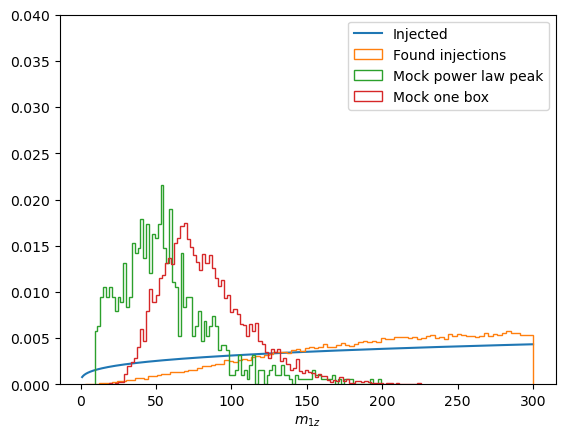

Maximum injected mass =  299.99860521793045
Maximum detected mass median (powerlaw peak)=  199.3135464309457
Maximum detected mass median (one-box)=  225.41821734966584
Maximum detected mass sample (one-box)=  264.4276224888929

Minimum injected mass =  3.104259643012184
Minimum detected mass median (powerlaw peak)=  9.256358937363405
Minimum detected mass median (one-box)=  18.63492097226223
Minimum detected mass sample (one-box)=  17.31730679112156


In [9]:
m1zs = np.linspace(mmin_inj,mmax_inj,10000)
pm_inj = gwpop.power_law(m1zs,0.3, mmin_inj,mmax_inj)
pm_inj = pm_inj / trapz(pm_inj,m1zs)
plt.plot(m1zs,pm_inj,label='Injected')
plt.hist(m1z_inj,bins=100,density=True, histtype='step',label='Found injections')
plt.hist(np.median(m1z_mock_samples,axis=1),bins=100,density=True, histtype='step',label='Mock power law peak')
plt.hist(np.median(m1z_mock_samples_onebox,axis=1),bins=100,density=True, histtype='step',label='Mock one box')
#plt.hist(m1z_inj,bins=100,density=True, histtype='step',weights=p_draw_inj,label='Weighted')
plt.xlabel(r'$m_{1z}$')
#plt.xlim([0,200])
plt.ylim([0,0.04])
plt.legend()
plt.show()

print('Maximum injected mass = ',np.max(m1z_inj))
print('Maximum detected mass median (powerlaw peak)= ',np.max(np.median(m1z_mock_samples,axis=1)))
print('Maximum detected mass median (one-box)= ',np.max(np.median(m1z_mock_samples_onebox,axis=1)))
print('Maximum detected mass sample (one-box)= ',np.max(np.max(m1z_mock_samples_onebox,axis=1)))
print('')
print('Minimum injected mass = ',np.min(m1z_inj))
print('Minimum detected mass median (powerlaw peak)= ',np.min(np.median(m1z_mock_samples,axis=1)))
print('Minimum detected mass median (one-box)= ',np.min(np.median(m1z_mock_samples_onebox,axis=1)))
print('Minimum detected mass sample (one-box)= ',np.min(np.min(m1z_mock_samples_onebox,axis=1)))

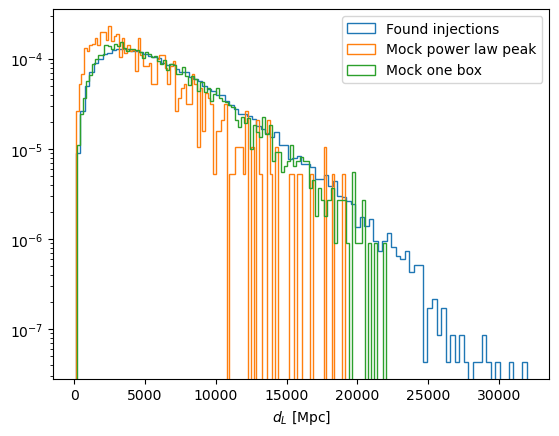

Maximum injected dL =  31958.360265635263
Maximum mock dL median (powerlaw peak) =  19235.22803043655
Maximum mock dL median (onebox) =  22099.5424979156
Maximum mock dL sample (onebox) =  25364.879233413354

Minimum injected dL =  104.93596862964411
Minimum mock dL median (powerlaw peak) =  112.43673795171055
Minimum mock dL median (onebox) =  159.06433174378844
Minimum mock dL sample (onebox) =  2.7187808001034637


In [10]:
plt.hist(dL_inj,bins=100,density=True, histtype='step',label='Found injections')
plt.hist(np.median(dL_mock_samples,axis=1),bins=100,density=True, histtype='step',label='Mock power law peak')
plt.hist(np.median(dL_mock_samples_onebox,axis=1),bins=100,density=True, histtype='step',label='Mock one box')
plt.xlabel(r'$d_L$ [Mpc]')
plt.yscale('log')
plt.legend()
plt.show()

print('Maximum injected dL = ',np.max(dL_inj))
print('Maximum mock dL median (powerlaw peak) = ',np.max(np.mean(dL_mock_samples,axis=1)))
print('Maximum mock dL median (onebox) = ',np.max(np.mean(dL_mock_samples_onebox,axis=1)))
print('Maximum mock dL sample (onebox) = ',np.max(np.max(dL_mock_samples_onebox,axis=1)))
print('')
print('Minimum injected dL = ',np.min(dL_inj))
print('Minimum mock dL median (powerlaw peak) = ',np.min(np.mean(dL_mock_samples,axis=1)))
print('Minimum mock dL median (onebox) = ',np.min(np.mean(dL_mock_samples_onebox,axis=1)))
print('Minimum mock dL sample (onebox) = ',np.min(np.min(dL_mock_samples_onebox,axis=1)))

Checking how the luminosity distance distribution depends on H0

In [27]:
n_sources = 10000
dLmax = 27000.

#Redshift
zmin = 1e-3
zmax = gwcosmo.z_at_dl_approx(dLmax,80.,Om0_fid)
print(zmax)
def dL_inj_Vc(H0,Om0,zmin,zmax,n_sources):
    
    zs = np.linspace(zmin,zmax,10000)
    cdf_z = cumtrapz(gwcosmo.diff_comoving_volume_approx(zs,H0,Om0)/(1+zs),zs,initial=0.0)
    norm_z = cdf_z[-1]
    cdf_z = cdf_z / norm_z
    #Geometric factor from orientations
    ww = np.linspace(0.0,1.0,1000)
    cdf_ww = 1.0-gwutils.pw_hl(ww)

    ##Computing injected events
    #----
    #Luminosity distance
    z_mock_pop = utils.inverse_transf_sampling(cdf_z,zs,n_sources)
    dL_mock_pop = gwcosmo.dL_approx(z_mock_pop,H0,Om0) #Mpc

    p_draw_z = gwcosmo.diff_comoving_volume_approx(z_mock_pop,H0,Om0)/(1+z_mock_pop)/norm_z
    Ez_i = gwcosmo.Ez_inv(z_mock_pop,H0,Om0)
    D_H = (Clight/1.0e3)  / H0 #Mpc 
    jac_logdLz = dL_mock_pop/(1.+z_mock_pop) + (1. + z_mock_pop)*D_H * Ez_i #Mpc
    p_draw_mock_pop = p_draw_z / jac_logdLz

    return dL_mock_pop, z_mock_pop

3.5562530067155067


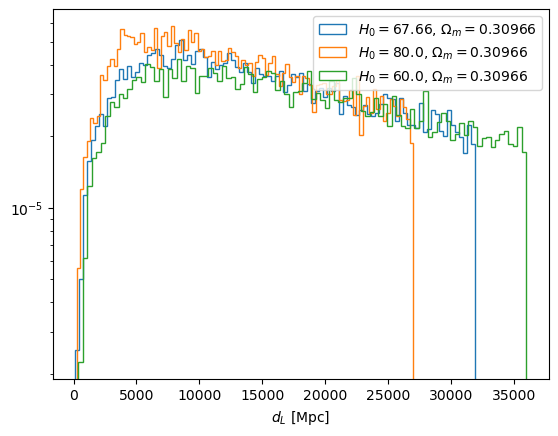

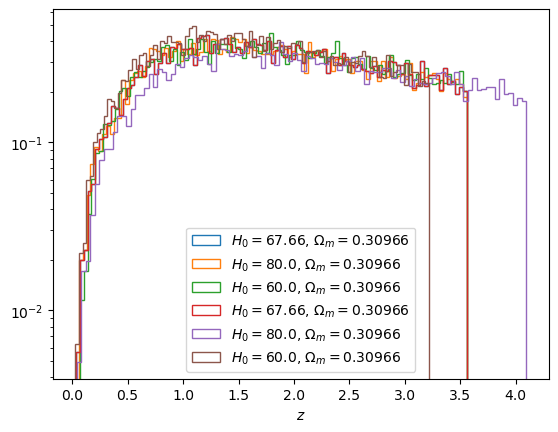

In [28]:
dL_mock_pop, z_mock_pop = dL_inj_Vc(H0_fid,Om0_fid,zmin,zmax,n_sources)
dL_mock_pop_2, z_mock_pop_2 = dL_inj_Vc(80.,Om0_fid,zmin,zmax,n_sources)
dL_mock_pop_3, z_mock_pop_3 = dL_inj_Vc(60.,Om0_fid,zmin,zmax,n_sources)

plt.hist(dL_mock_pop,bins=100,density=True, histtype='step',label='$H_0=%s$, $\Omega_m=%s$'%(H0_fid,Om0_fid))
plt.hist(dL_mock_pop_2,bins=100,density=True, histtype='step',label='$H_0=%s$, $\Omega_m=%s$'%(80.,Om0_fid))
plt.hist(dL_mock_pop_3,bins=100,density=True, histtype='step',label='$H_0=%s$, $\Omega_m=%s$'%(60.,Om0_fid))
plt.yscale('log')
plt.xlabel(r'$d_L$ [Mpc]')
plt.legend()
plt.show()

zs = gwcosmo.z_at_dl_approx(dL_mock_pop,H0_fid,Om0_fid)
zs_2 = gwcosmo.z_at_dl_approx(dL_mock_pop,80.,Om0_fid)
zs_3 = gwcosmo.z_at_dl_approx(dL_mock_pop,60.,Om0_fid)

plt.hist(z_mock_pop,bins=100,density=True, histtype='step',label='$H_0=%s$, $\Omega_m=%s$'%(H0_fid,Om0_fid))
plt.hist(z_mock_pop_2,bins=100,density=True, histtype='step',label='$H_0=%s$, $\Omega_m=%s$'%(80.,Om0_fid))
plt.hist(z_mock_pop_3,bins=100,density=True, histtype='step',label='$H_0=%s$, $\Omega_m=%s$'%(60.,Om0_fid))
plt.hist(zs,bins=100,density=True, histtype='step',label='$H_0=%s$, $\Omega_m=%s$'%(H0_fid,Om0_fid))
plt.hist(zs_2,bins=100,density=True, histtype='step',label='$H_0=%s$, $\Omega_m=%s$'%(80.,Om0_fid))
plt.hist(zs_3,bins=100,density=True, histtype='step',label='$H_0=%s$, $\Omega_m=%s$'%(60.,Om0_fid))
plt.yscale('log')
plt.xlabel(r'$z$')
plt.legend(loc='lower center')
plt.show()

array([2.04841961, 0.50022076, 3.04599385, ..., 2.49628228, 0.63033988,
       2.24919576])